In [1]:
import re
import numpy as np
import pandas as pd
import pymssql
import openai
from langchain_groq import ChatGroq
from MilvusRetriever import MilvusRetriever
from dotenv import load_dotenv
import yaml
from datetime import datetime, date
from functools import lru_cache
import random
import uuid

import os
import json
import dateutil
import getpass
from typing import Annotated, Optional, Literal
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

from langgraph.graph.message import AnyMessage, add_messages
from langgraph.graph import END, StateGraph, START
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig
from langchain_core.messages import ToolMessage, HumanMessage, AIMessage
from langchain_core.runnables import RunnableLambda
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition, ToolInvocation
from langgraph.checkpoint.memory import MemorySaver
from langgraph.errors import NodeInterrupt
from langchain_openai import ChatOpenAI

from IPython.display import Image, display


In [2]:
# Load environment variables
load_dotenv()
data_cache = {}

# Chat history cache
chat_history_cache = {}
with open("config.yaml", 'r') as file:
        config = yaml.safe_load(file)
        database_config = config.get('database', {})
        user = database_config.get('username')
        password = database_config.get('password')

In [3]:
retriever = MilvusRetriever(documents=[],k=3)
retriever.init()

Fetching 30 files:   0%|          | 0/30 [00:00<?, ?it/s]

/home/fermikira/anaconda3/envs/llms_env/lib/python3.12/site-packages/FlagEmbedding/BGE_M3/modeling.py:335: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  colbert_state_dict =

Loading existing collection: hybrid_rag


# Define LLM

In [4]:
load_dotenv()

True

In [5]:
llm = ChatOpenAI(temperature=0)

In [6]:
llm = ChatGroq(groq_api_key=os.environ['GROQ_API_KEY'], model_name="llama3-70b-8192")

# Define STATE:

In [7]:
class RequiredInformation(BaseModel):
    provided_id: Optional[int] = Field(None,description="La cédula que proporcionó el usuario")
    provided_email: Optional[str] = Field(None,description="El email que proporcionó el usuario")
    
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    required_information: RequiredInformation
    is_validated: bool = False
    telephone : int
    has_credit: bool = False
    state_history: list[str, add_messages]

# Define TOOLS:

In [8]:
@tool
def es_correo_valido(correo: str) -> bool:
    """ Función que verifica si el correo proporcionado por el usuario está en formato estandar.

    Args:
        correo (str): correo proporcionado por el usuario

    Returns:
        bool: True si el correo es correcto, False si el correo no está en formato estandar.
    """
    # Expresión regular para validar correos electrónicos
    patron = r'^[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$'
    
    # Verificar si el correo cumple con el patrón
    if re.match(patron, correo):
        return True
    else:
        return False

In [9]:
@tool
def es_fecha_valida(fecha: str) -> bool:
    """Función que verifica si la fecha proporcionada por el usuario está en formato %AAAA-MM-DD%.

    Args:
        fecha (str): 

    Returns:
        bool: True si la fecha es correcta, False si la fecha no es valida
    """
    try:
        # Intentamos convertir la cadena a un objeto de fecha con el formato %Y-%m-%d
        datetime.strptime(fecha, '%Y-%m-%d')
        return True
    except ValueError:
        # Si ocurre un ValueError, significa que el formato no es correcto
        return False

In [10]:
tools = [es_correo_valido, es_fecha_valida]
tool_node = ToolNode(tools)

# Define NODE FUNCTIONS:

In [11]:
def telephone_check_node(state: State):
    print('on the telephone check node')
    Telefono = state['telephone']
    try:
        cnxn = pymssql.connect(server='192.168.50.38\\DW_FZ', database='DW_FZ', user=user, password=password)
        query4 = f"""
        SELECT CD.id_persona AS CEDULA, CD.numero_id AS NUMERO_CREDITO, CD.id_fecha_nacimiento AS FECHA_NACIMIENTO, DC.Telefono AS TELEFONO, DC.Correo AS CORREO, DC.Nombre as NOMBRE
        FROM DW_FZ.dbo.CRM_Datos_Cliente as DC
        LEFT JOIN DW_FZ.dbo.Dim_Cred_Demografico AS CD
        ON CD.id_persona = DC.Cedula  Where TELEFONO = '{Telefono}';
        """
        INFO_CL = pd.read_sql_query(query4, cnxn)
        if not INFO_CL.empty:
            print(f"Tiene cuenta validada correctamente.")
            return {'has_credit':True,"state_history":"telephone_check_node"}
        else:
            print(f"Cuenta no encontrada en la base de datos.")
            return {'has_credit':False}
    except Exception as e:
        print(f"Error al validar teléfono: {e}")
        return {'has_credit':False}
    
def loguer_node(state: State) -> dict:
    print("En el saludo", state)
    loguer_system = """
                    Eres un asistente de Finanzauto, una empresa de financiación de vehiculos en Colombia. Tu objetivo es autenticar al cliente con su información personal. Para esto
                    necesitas recolectar la información.
                    
                    Instrucciones:
                    1. Saluda de forma amable, cordial y concisa al cliente Y luego dile que va a pasar a un proceso de verificación
                    donde le va a pedir su correo electrónico registrado con Finanzauto o su fecha de nacimiento.
                    
                    2. Pide el correo electrónico registrado con Finanzauto o la fecha de nacimiento. Nunca intentes inventar ninguna información, solo pregunta por ella.
                    
                    3. Si la informació
                    Historico de la conversación: {messages}
                    Información que el usuario ha proporcionado: {required_information}
                """
    loguer_prompt = ChatPromptTemplate.from_template(loguer_system)
    loguer_chain = loguer_prompt | llm
    response = loguer_chain.invoke(
        {
            "messages": state["messages"],
            "required_information": state["required_information"] if "required_information" in state else None
        }
    )
    return {"messages": [response]} 

def verifier_node(state: State) -> dict:
    print("En el verificador", state)
    loguer_system = """
                    Eres un verificador que mira el último mensaje humano y verifica si en este mensaje se encuentra una fecha de nacimiento o un correo electrónico.
                    Si se encuentra la fecha, entonces pon la fecha en el formato 'A-M-D.
                    Pon el campo encontrado en el siguiente formato:
                    
                    class RequiredInformation(BaseModel):
                        provided_date: Optional[int] = Field(None,description="La fecha que proporcionó el usuario en el formato A-M-D")
                        provided_email: Optional[str] = Field(None,description="El email que proporcionó el usuario")
                    
                    Ultimo mensaje humano: {last_human_message}
                """
    messages = state['messages']
    # Filter for only HumanMessage types
    human_messages = [msg for msg in messages if isinstance(msg, HumanMessage)]
    # Return the last human message
    last_human_message = human_messages[-1].content if human_messages else None
    print(last_human_message)
    loguer_prompt = ChatPromptTemplate.from_template(loguer_system)
    loguer_chain = loguer_prompt | llm.with_structured_output(RequiredInformation)
    response = loguer_chain.invoke(
        {
            "last_human_message": last_human_message
        }
    )
    print(response)
    return {"required_information":response } 


def general_assistant(state: State) -> RequiredInformation:
    loguer_system = """
                    Eres un asistente de Finanzauto, una empresa de financiación de vehiculos en Colombia.
                    - Responde como un asesor de servicio al cliente atento, amable, considerado, alegre, cordial, amigable y preciso.
                    - Saluda amablemente y pregunta el nombre solo al iniciar la conversación.
                    - Responde de manera concisa y orientada a resolver las dudas del cliente.
                    - Usa el nombre del cliente si está disponible, pero evita saludar constantemente con "Hola".
                    - Responde "No tengo esa información" si careces de datos suficientes.
                    - NUNCA inventes información. Usa solo los datos proporcionados en el contexto.
                    - Responde ÚNICAMENTE preguntas relacionadas con el servicio al cliente de Finanzauto.
                    - Utiliza los siguientes documentos relevantes para responder las preguntas del cliente. Pero no menciones estos
                    documentos explicitamente, solo responde la pregunta
                    Documentos relevantes: {relevant_docs}
                """
    messages = state['messages']
    human_messages = [msg for msg in messages if isinstance(msg, HumanMessage)]
    # Return the last human message
    last_human_message = human_messages[-1] if human_messages else None
    loguer_prompt = ChatPromptTemplate.from_template(loguer_system)
    loguer_chain = loguer_prompt | llm
    response = loguer_chain.invoke(
        {
            "messages": state["messages"],
            "relevant_docs":  retriever.invoke(last_human_message)
        }
    )
    return {"messages": [response]} 

def verificado(state: State):
    print("VERIFICADO!!!")
    return {'verificado':True}

# Define EDGE FUNCTIONS

In [12]:
def manage_verifier(state) -> Literal[ "__end__", 'verificado']:
    print("ON EDGE: GET STATE")
    messages = state["messages"]
    print(messages[-1])
    if not isinstance(messages[-1], HumanMessage):
        print("NEXT NODE: HUMAN RESPONSE (END)")
        return END
    elif state['validated']:
        print("Next node: Validado")
        return 'verificado'
    else:
        return END
    
def manage_incoming_msg(state: State) -> Literal["verifier","telephone_check"]:
    print('en el inicio')
    print(state['messages'])
    if len(state["messages"]) == 1:
        print('telephone_check')
        return "telephone_check"
    elif isinstance(state["messages"][-1], HumanMessage):
        print('next node: verifier')
        return "verifier"
    
def manage_telephone_check(state: State) -> Literal["loguer", "general_assistant"]:
    print('manejando telefono')
    has_credit = state["has_credit"] 
    if has_credit:
        return "loguer"
    else:
        return "general_assistant"


# Define GRAPH:

In [13]:
workflow = StateGraph(State)
workflow.add_node("telephone_check", telephone_check_node)
workflow.add_node("loguer", loguer_node)
workflow.add_node("verifier", verifier_node)
workflow.add_node("verificado", verificado)
workflow.add_node("general_assistant", general_assistant)

workflow.add_conditional_edges(START,manage_incoming_msg)
workflow.add_conditional_edges("telephone_check", manage_telephone_check)
workflow.add_conditional_edges("verifier",manage_verifier)
workflow.add_edge("loguer", END)
workflow.add_edge("verificado", END)


# Compile GRAPH

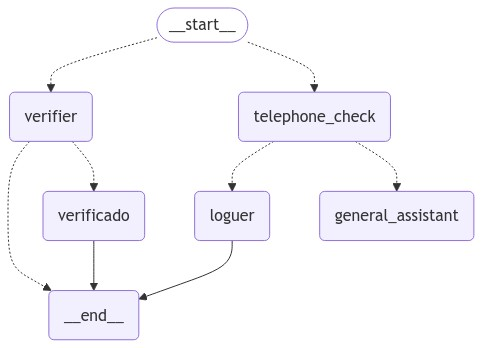

In [14]:
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
graph.get_graph().draw_mermaid_png(output_file_path="graph.png")
display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:

config = {"configurable": {"thread_id": 8}}
graph.invoke({"messages":'HOLA!', "telephone":"3104668957"}, config=config)

en el inicio
[HumanMessage(content='HOLA!', additional_kwargs={}, response_metadata={}, id='9d18a85b-f9f4-4a0f-8a79-14de6c6ebd75')]
telephone_check
on the telephone check node


/tmp/ipykernel_369454/4157267812.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  INFO_CL = pd.read_sql_query(query4, cnxn)


Tiene cuenta validada correctamente.
manejando telefono
En el saludo {'messages': [HumanMessage(content='HOLA!', additional_kwargs={}, response_metadata={}, id='3ee01c11-63d8-472c-928f-b6126ded53f5')], 'telephone': '3104668957', 'has_credit': True, 'state_history': 'telephone_check_node'}


{'messages': [HumanMessage(content='HOLA!', additional_kwargs={}, response_metadata={}, id='3ee01c11-63d8-472c-928f-b6126ded53f5'),
  AIMessage(content='Hola! Bienvenido a Finanzauto. Me alegra atenderte. Antes de continuar, necesitamos verificar su identidad para asegurarnos de que estamos hablando con el dueño del vehículo. Para hacer esto, necesito pedirle algunos datos personales. ¿Podría proporcionarme su correo electrónico registrado con Finanzauto o su fecha de nacimiento, por favor?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 86, 'prompt_tokens': 227, 'total_tokens': 313, 'completion_time': 0.272675026, 'prompt_time': 0.011050429, 'queue_time': 0.00450736, 'total_time': 0.283725455}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_c1a4bcec29', 'finish_reason': 'stop', 'logprobs': None}, id='run-925c7a6d-401d-49b6-8582-e173b0c591ba-0', usage_metadata={'input_tokens': 227, 'output_tokens': 86, 'total_tokens': 313})],
 'telephone': '3

In [16]:
graph.invoke({"messages":['lipedanlr@gmail.com','aaa'], "telephone":"3104668957"}, config=config)

en el inicio
[HumanMessage(content='HOLA!', additional_kwargs={}, response_metadata={}, id='3ee01c11-63d8-472c-928f-b6126ded53f5'), AIMessage(content='Hola! Bienvenido a Finanzauto. Me alegra atenderte. Antes de continuar, necesitamos verificar su identidad para asegurarnos de que estamos hablando con el dueño del vehículo. Para hacer esto, necesito pedirle algunos datos personales. ¿Podría proporcionarme su correo electrónico registrado con Finanzauto o su fecha de nacimiento, por favor?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 86, 'prompt_tokens': 227, 'total_tokens': 313, 'completion_time': 0.272675026, 'prompt_time': 0.011050429, 'queue_time': 0.00450736, 'total_time': 0.283725455}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_c1a4bcec29', 'finish_reason': 'stop', 'logprobs': None}, id='run-925c7a6d-401d-49b6-8582-e173b0c591ba-0', usage_metadata={'input_tokens': 227, 'output_tokens': 86, 'total_tokens': 313}), HumanMessage(conten

KeyError: 'validated'

In [17]:
import uuid
import asyncio
import nest_asyncio
from langchain_core.messages import HumanMessage

# Allow nested event loops
nest_asyncio.apply()

config = {"configurable": {"thread_id": 21321}}

async def handle_input():
    while True:
        user = input("User (q/Q to quit): ")
        print(f"User (q/Q to quit): {user}")
        if user in {"q", "Q"}:
            print("AI: Byebye")
            break

        await stream_output(user)
        await asyncio.sleep(1)

async def stream_output(user_input):
    output = None
    async for output in graph.astream(
        {"messages": [HumanMessage(content=user_input)], "telephone":'3104668957'}, config=config, stream_mode="updates"
    ):  
        try:
            last_message = next(iter(output.values()))["messages"][-1]
            last_message.pretty_print()
        except:
            pass
        if output and "prompt" in output:
            print("Done!")

# Start the input handling task
await handle_input()


User (q/Q to quit): Hola!
en el inicio
[HumanMessage(content='Hola!', additional_kwargs={}, response_metadata={}, id='3cb1f9e6-0a98-4568-9a55-1d824deec7f1')]
telephone_check
on the telephone check node


/tmp/ipykernel_369454/4157267812.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  INFO_CL = pd.read_sql_query(query4, cnxn)


Tiene cuenta validada correctamente.
manejando telefono
En el saludo {'messages': [HumanMessage(content='Hola!', additional_kwargs={}, response_metadata={}, id='3cb1f9e6-0a98-4568-9a55-1d824deec7f1')], 'telephone': '3104668957', 'has_credit': True, 'state_history': 'telephone_check_node'}
================================== Ai Message ==================================

Hola! Bienvenido a Finanzauto. Me alegra atenderte. Antes de continuar, necesito verificar su identidad para asegurarme de que estamos hablando con el propietario del vehículo. Para hacer esto, necesito pedirle algunos datos personales. ¿Podría proporcionarme su correo electrónico registrado con Finanzauto o su fecha de nacimiento, por favor?
User (q/Q to quit): lipedanlr@gmail.com
en el inicio
[HumanMessage(content='Hola!', additional_kwargs={}, response_metadata={}, id='3cb1f9e6-0a98-4568-9a55-1d824deec7f1'), AIMessage(content='Hola! Bienvenido a Finanzauto. Me alegra atenderte. Antes de continuar, necesito verificar s

KeyError: 'validated'